In [56]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "EMERGENCY"]


In [57]:
data = pd.read_excel('/content/combined_dataset_401_442.xlsx')
data.head()

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3,INOP_PLETH,INOP_SpO2,INOP_RESP,INOP_NOISE,ALARM,Alarm Spo2,Alarm HR,Alarm ABP2,Alarm Resp,Alarm ABP1,Alarm
0,94.0,71.0,71.0,19.0,69.0,113.0,50.0,0,0,0,0,0,False,False,False,False,False,False
1,94.0,71.0,71.0,19.0,69.0,113.0,50.0,0,0,0,0,0,False,False,False,False,False,False
2,94.0,71.0,71.0,17.0,70.0,113.0,51.0,0,0,0,0,0,False,False,False,False,False,False
3,94.0,71.0,71.0,17.0,69.0,113.0,51.0,0,0,0,0,0,False,False,False,False,False,False
4,94.0,71.0,71.0,17.0,69.0,113.0,50.0,0,0,0,0,0,False,False,False,False,False,False


In [58]:
columns_to_delete = [ 'INOP_PLETH','INOP_SpO2', 'INOP_RESP', 'INOP_NOISE','Alarm Spo2','Alarm HR','Alarm ABP2','Alarm Resp','Alarm ABP1','ALARM']
data.drop(columns=columns_to_delete, inplace=True)

data.dropna( inplace = True)
data.reset_index(drop = True, inplace = True)

data.head()

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3,Alarm
0,94.0,71.0,71.0,19.0,69.0,113.0,50.0,False
1,94.0,71.0,71.0,19.0,69.0,113.0,50.0,False
2,94.0,71.0,71.0,17.0,70.0,113.0,51.0,False
3,94.0,71.0,71.0,17.0,69.0,113.0,51.0,False
4,94.0,71.0,71.0,17.0,69.0,113.0,50.0,False


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201285 entries, 0 to 201284
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SpO2    201285 non-null  float64
 1   HR      201285 non-null  float64
 2   PULSE   201285 non-null  float64
 3   RESP    201285 non-null  float64
 4   ABP1    201285 non-null  float64
 5   ABP2    201285 non-null  float64
 6   ABP3    201285 non-null  float64
 7   Alarm   201285 non-null  bool   
dtypes: bool(1), float64(7)
memory usage: 10.9 MB


In [60]:
data.dropna(inplace = True)
data.reset_index(drop = True, inplace = True)

columns_to_check = data.columns[data.columns != "Alarm"]
data = data.loc[(data[columns_to_check] != 0).all(axis=1)]
#data = data.loc[(data != 0).all(axis=1)]

In [61]:
data.shape

(167738, 8)

In [62]:
data.head()

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3,Alarm
0,94.0,71.0,71.0,19.0,69.0,113.0,50.0,False
1,94.0,71.0,71.0,19.0,69.0,113.0,50.0,False
2,94.0,71.0,71.0,17.0,70.0,113.0,51.0,False
3,94.0,71.0,71.0,17.0,69.0,113.0,51.0,False
4,94.0,71.0,71.0,17.0,69.0,113.0,50.0,False


In [63]:
data['Alarm']=data['Alarm'].astype(int)
data.head()

<ipython-input-63-5b58914fc4dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Alarm']=data['Alarm'].astype(int)


,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3,Alarm
0,94.0,71.0,71.0,19.0,69.0,113.0,50.0,0
1,94.0,71.0,71.0,19.0,69.0,113.0,50.0,0
2,94.0,71.0,71.0,17.0,70.0,113.0,51.0,0
3,94.0,71.0,71.0,17.0,69.0,113.0,51.0,0
4,94.0,71.0,71.0,17.0,69.0,113.0,50.0,0


## Exploratory Data Analysis

In [64]:
data.isnull().values.any()

False

In [65]:
# data.loc[data['ALARM'] != 0, 'ALARM'] = 1
print(data['Alarm'].unique())

[0 1]


In [66]:
data['Alarm'] = data['Alarm'].astype(float)

<ipython-input-66-5aa8777f2576>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Alarm'] = data['Alarm'].astype(float)


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167738 entries, 0 to 201284
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SpO2    167738 non-null  float64
 1   HR      167738 non-null  float64
 2   PULSE   167738 non-null  float64
 3   RESP    167738 non-null  float64
 4   ABP1    167738 non-null  float64
 5   ABP2    167738 non-null  float64
 6   ABP3    167738 non-null  float64
 7   Alarm   167738 non-null  float64
dtypes: float64(8)
memory usage: 11.5 MB


Text(0, 0.5, 'Frequency')

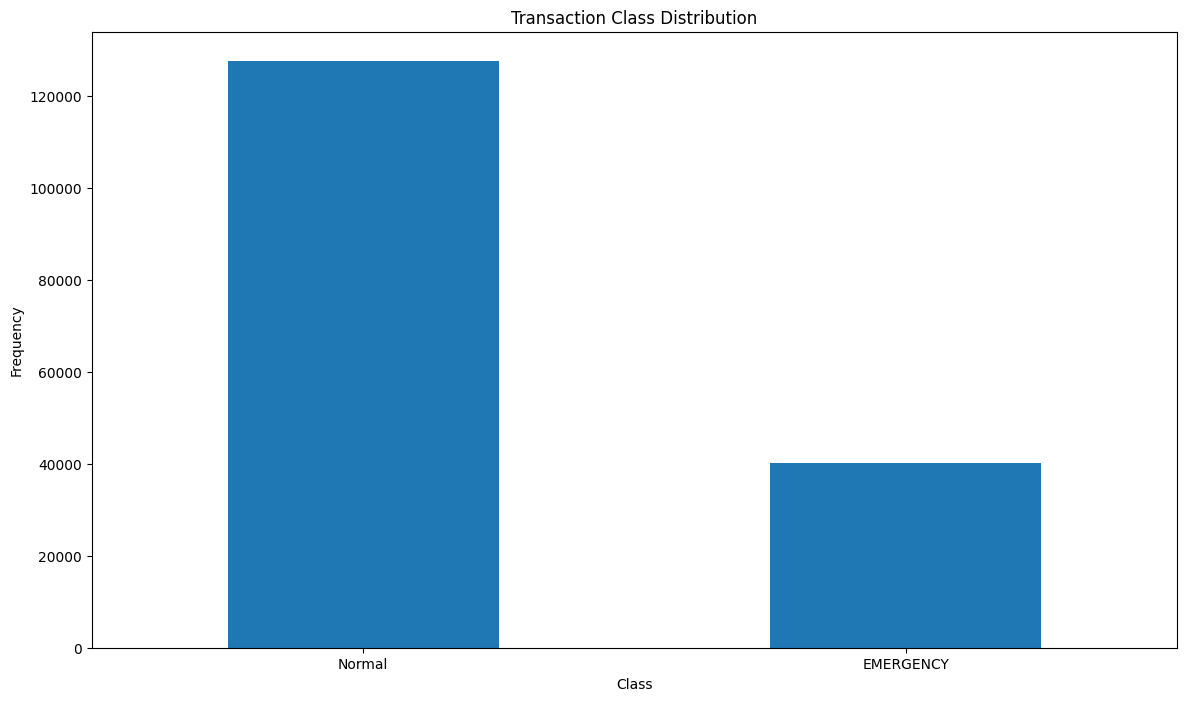

In [68]:
count_classes = pd.value_counts(data['Alarm'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [69]:
## Get the Fraud and the normal dataset

emergency = data[data['Alarm']==1]

normal = data[data['Alarm']==0]

In [70]:
print(emergency.shape,normal.shape)

(40184, 8) (127554, 8)


#Box Plot

In [71]:
# # Take some sample of the data
# def box_plot(data, feature):
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=feature, data=data)
#     plt.show()

# # Function to check if a subset contains any anomalies
# def has_anomalies(data, feature):
#     Q1 = data[feature].quantile(0.25)
#     Q3 = data[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     filter = (data[feature] >= Q1 - 1.5 * IQR) & (data[feature] <= Q3 + 1.5 * IQR)
#     return not filter.all()

# # Assuming 'df' is your DataFrame
# feature = 'Alarm'
# subset_size = 7584  # Change this to control the size of the subset

# while True:
#     # Randomly select a subset from the DataFrame
#     data1 = data.sample(n=subset_size)

#     # Check the 'Alarm' feature for anomalies
#     if has_anomalies(data1, feature):
#         # If anomalies are found, create a box plot and break the loop
#         box_plot(data1, feature)
#         break


data1= data.sample(frac = 0.1)

data1.shape

(16774, 8)

In [72]:
data.shape

(167738, 8)

In [73]:
#Determine the number of fraud and valid transactions in the dataset

Emergency = data1[data1['Alarm']==1]

Valid = data1[data1['Alarm']==0]

outlier_fraction = len(Emergency)/float(len(Valid))

In [74]:
print(outlier_fraction)

print("Emergency Cases : {}".format(len(Emergency)))

print("Valid Cases : {}".format(len(Valid)))

0.3159174707774378
Emergency Cases : 4027
Valid Cases : 12747


In [75]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Alarm"]]
# Store the variable we are predicting
target = "Alarm"
# Define a random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)


(16774, 7)
(16774,)


In [76]:
print(X_outliers)

[[0.37454012 0.95071431 0.73199394 ... 0.15601864 0.15599452 0.05808361]
 [0.86617615 0.60111501 0.70807258 ... 0.96990985 0.83244264 0.21233911]
 [0.18182497 0.18340451 0.30424224 ... 0.43194502 0.29122914 0.61185289]
 ...
 [0.19438995 0.30315587 0.57227623 ... 0.89215954 0.77460053 0.5283641 ]
 [0.8656293  0.54850255 0.08867125 ... 0.48064376 0.69428527 0.34611161]
 [0.36029926 0.94201465 0.91907701 ... 0.41486211 0.74953482 0.93966402]]


In [77]:
# smote = SMOTE(random_state=RANDOM_SEED)
# X_resampled, y_resampled = smote.fit_resample(X, Y)

# print(X_resampled.shape)
# print( np.sum(y_resampled == 1))

In [78]:
##train test splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import regularizers

# Assuming 'data1' is your dataset and 'columns' are the features
# X_train = data1[columns]

# Define the architecture of the neural network
# model = Sequential([
#     Dense(64, activation='relu'),  # Input layer with 64 neurons
#     Dense(32, activation='relu'),                                  # Hidden layer with 32 neurons
#     Dense(16, activation='relu'),                                  # Hidden layer with 32 neurons
#     Dense(8, activation='relu'),                                  # Hidden layer with 32 neurons
#     Dense(4, activation='relu')                   # Output layer with 9 neurons (for autoencoder)
# ]))
# Define the architecture of the neural network

model1 = Sequential([
    Dense(4, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),  # Input layer with 64 neurons
    Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),                                  # Hidden layer with 32 neurons
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),                                  # Hidden layer with 32 neurons
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),                                  # Hidden layer with 32 neurons
    Dense(X_train.shape[1], activation='sigmoid')                                                           # Output layer with 9 neurons (for autoencoder)
])

# model1 = Sequential([
#     Dense(4, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 64 neurons
#     Dense(8, activation='relu'),                                  # Hidden layer with 32 neurons

#     Dense(16, activation='relu'),                                  # Hidden layer with 32 neurons
#     Dense(32, activation='relu'),                                  # Hidden layer with 32 neurons
#     Dense(X_train.shape[1], activation='sigmoid')                   # Output layer with 9 neurons (for autoencoder)
# ])
# Compile the model
model1.compile(optimizer='adam', loss='mse')  # Using mean squared error for autoencoder

# Train the model
model1.fit(X_train, X_train, epochs=10)

# Extract features using the trained model
extracted_features = model1.predict(X_train)


# Now 'extracted_features' can be used as input for another model
X_train=extracted_features

Epoch 1/10
420/420 [==============================] - 2s 2ms/step - loss: 749138368.0000
Epoch 2/10
420/420 [==============================] - 1s 2ms/step - loss: 749143296.0000
Epoch 3/10
420/420 [==============================] - 1s 2ms/step - loss: 749144192.0000
Epoch 4/10
420/420 [==============================] - 1s 3ms/step - loss: 749143616.0000
Epoch 5/10
420/420 [==============================] - 1s 3ms/step - loss: 749140928.0000
Epoch 6/10
420/420 [==============================] - 1s 3ms/step - loss: 749143616.0000
Epoch 7/10
420/420 [==============================] - 1s 3ms/step - loss: 749141504.0000
Epoch 8/10
420/420 [==============================] - 1s 2ms/step - loss: 749139392.0000
Epoch 9/10
420/420 [==============================] - 1s 2ms/step - loss: 749138304.0000
Epoch 10/10
420/420 [==============================] - 1s 1ms/step


## Model Prediction

In [79]:
#Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination='auto',random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination='auto'),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
                                         max_iter=-1, )

}

In [80]:
type(classifiers)

dict

In [81]:
n_outliers = len(Emergency)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_test)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X_test)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X_test)
        # print(scores_prediction)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions

    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_test).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_test,y_pred))
    print("Classification Report :")
    print(classification_report(y_test,y_pred))

Isolation Forest: 793
Accuracy Score :
0.7636363636363637
Classification Report :
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      2543
         1.0       0.77      0.03      0.06       812

    accuracy                           0.76      3355
   macro avg       0.77      0.52      0.46      3355
weighted avg       0.77      0.76      0.67      3355

Local Outlier Factor: 891
Accuracy Score :
0.7344262295081967
Classification Report :
              precision    recall  f1-score   support

         0.0       0.76      0.95      0.84      2543
         1.0       0.25      0.05      0.08       812

    accuracy                           0.73      3355
   macro avg       0.51      0.50      0.46      3355
weighted avg       0.64      0.73      0.66      3355

Support Vector Machine: 1197
Accuracy Score :
0.6432190760059613
Classification Report :
              precision    recall  f1-score   support

         0.0       0.78      0.73 

#Voting Classifier

In [82]:
# class OutlierDetector(BaseEstimator, ClassifierMixin):
#     def __init__(self, model):
#         self.model = model

#     def fit(self, X, y=None):
#         self.model.fit(X)
#         return self

#     def predict(self, X):
#         if isinstance(self.model, LocalOutlierFactor):
#             outlier_scores = -self.model.negative_outlier_factor_
#         else:
#             outlier_scores = self.model.decision_function(X)
#         return (outlier_scores < 0).astype(int)

# # Define the outlier detection models
# isolation_forest = IsolationForest(n_estimators=100, max_samples=len(X),
#                                    contamination='auto', random_state=state, verbose=0)
# lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
#                          leaf_size=30, metric='minkowski',
#                          p=2, metric_params=None, contamination='auto')
# svm = OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05,
#                   max_iter=-1)

# # Create custom estimators for outlier detection
# if_estimator = OutlierDetector(isolation_forest)
# lof_estimator = OutlierDetector(lof)
# svm_estimator = OutlierDetector(svm)

# # Define the voting classifier
# voting_classifier = VotingClassifier(
#     estimators=[
#         ('Isolation Forest', if_estimator),
#         ('Local Outlier Factor', lof_estimator),
#         ('One-Class SVM', svm_estimator)
#     ],
#     voting='hard'
# )

# # Fit the voting classifier
# voting_classifier.fit(X, Y)

# # Predict outliers using the voting classifier
# y_pred_voting = voting_classifier.predict(X)

# # Calculate the number of errors with the voting classifier
# n_errors_voting = (y_pred_voting != Y).sum()

# # Run Classification Metrics for the voting classifier
# print("Voting Classifier: {}".format(n_errors_voting))
# print("Accuracy Score for Voting Classifier:")
# print(accuracy_score(Y, y_pred_voting))
# print("Classification Report for Voting Classifier:")
# print(classification_report(Y, y_pred_voting))

#Correlation Matrix

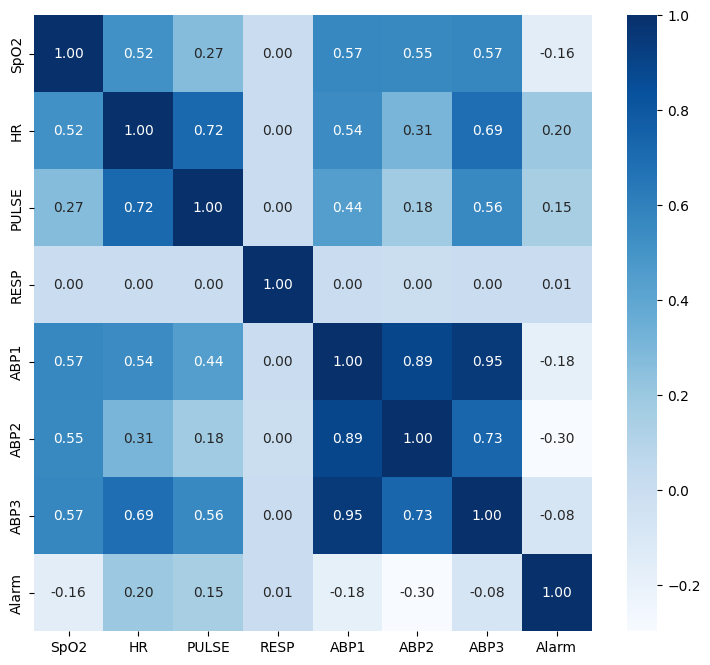

In [83]:
corr_matrix = data.corr()
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.show()

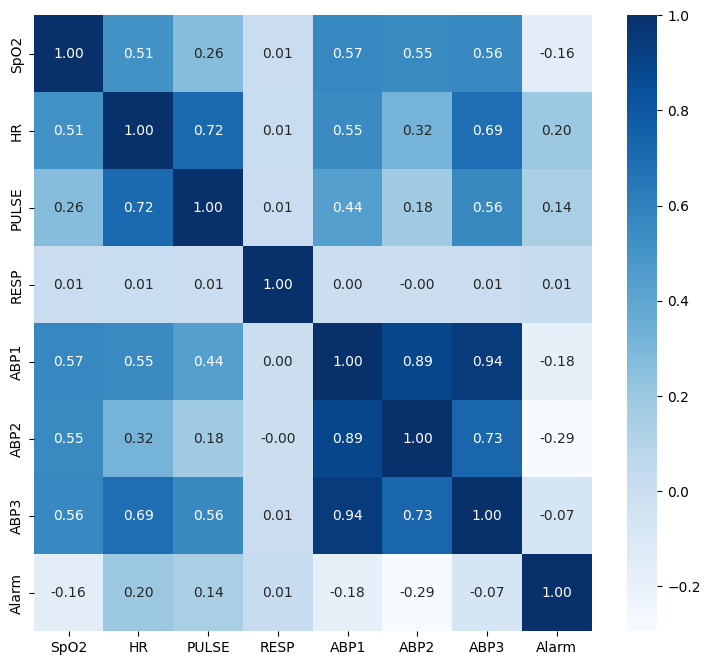

In [84]:
corr_matrix = data1.corr()
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.show()